In [1]:
import gym
import pandas
import numpy as np

env = gym.make('CartPole-v0')

In [ ]:
env.env?

In [2]:
old_observation = env.reset()
new_action = env.action_space.sample()
env.step(new_action)

(array([-0.04470379, -0.1539854 ,  0.01456947,  0.27373274]), 1.0, False, {})

In [3]:
num_episodes = 1000

life_memory = []

for i in range(num_episodes):
    old_observation = env.reset()
    done = False
    tot_reward = 0
    ep_memory = []
    while not done:
        new_action = env.action_space.sample()
        observation, reward, done, info = env.step(new_action)
        tot_reward += reward
        
        ep_memory.append({
            "obs0": old_observation[0],
            "obs1": old_observation[1],
            "obs2": old_observation[2],
            "obs3": old_observation[3],
            "action": new_action,
            "reward": reward,
            "episode": i,
        })
        old_observation = observation
        
    for ep_mem in ep_memory:
        ep_mem["tot_reward"] = tot_reward
        
    life_memory.extend(ep_memory)
    
memory_df = pandas.DataFrame(life_memory)


In [ ]:
memory_df

In [4]:
memory_df.groupby("episode").reward.sum().mean()
memory_df["comb_reward"] = .5*memory_df.reward + 1.2 * memory_df.tot_reward

In [ ]:
memory_df

In [ ]:
cnt = [i for i in memory_df.groupby("episode").count().tot_reward]

In [ ]:
a = []
for j in range(len(cnt)):
    for i in range(1, cnt[j] + 1):
        a.append(i / cnt[j])

In [ ]:
memory_df2 = memory_df.copy()
memory_df2["res_reward"] = memory_df.tot_reward * a

In [ ]:
memory_df2.describe()

In [ ]:
memory_df2.groupby("episode").reward.sum().mean()
memory_df2["comb_reward"] = .5*memory_df.reward + memory_df2.res_reward

In [ ]:
memory_df2

In [5]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
import datetime

n = datetime.datetime.now
t = n()

RandomForest = RandomForestRegressor()
RandomForest.fit(memory_df[["obs0", "obs1", "obs2", "obs3", "action"]], memory_df.comb_reward)
print(f"Training time: {n() - t}s")

Training time: 0:00:11.463180s


In [ ]:
n = datetime.datetime.now
t = n()

RandomForest2 = RandomForestRegressor()
RandomForest2.fit(memory_df[["obs0", "obs1", "obs2", "obs3", "action"]], memory_df2.comb_reward)
print(f"Training time: {n() - t}s")

In [ ]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(memory_df[["obs0", "obs1", "obs2", "obs3", "action"]], memory_df.comb_reward)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor

ExtraTrees = ExtraTreesRegressor()
ExtraTrees.fit(memory_df[["obs0", "obs1", "obs2", "obs3", "action"]], memory_df.comb_reward)

In [ ]:
t = n()
num_episodes = 100
a_life_memory = []
a_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    a_old_observation = a_env.reset()
    a_done = False
    a_tot_reward = 0
    a_em_memory = []
    
    while not a_done:
        pred_in = [list(a_old_observation) + [i] for i in range(2)]
        a_new_action = np.argmax(AdaBoost.predict(pred_in))
        a_observation, a_reward, a_done, a_info = a_env.step(a_new_action)
        a_tot_reward += a_reward
        
        a_em_memory.append({
            "obs0": a_old_observation[0],
            "obs1": a_old_observation[1],
            "obs2": a_old_observation[2],
            "obs3": a_old_observation[3],
            "action": a_new_action,
            "reward": a_reward,
            "episode": i,
        })
        
        a_old_observation = a_observation

    for a_em in a_em_memory:
        a_em["tot_reward"] = a_tot_reward
        
    a_life_memory.extend(a_em_memory)
a_memory_df = pandas.DataFrame(a_life_memory)
print(f"Training time: {n() - t}s")

In [ ]:
a_memory_df.shape

In [ ]:
RandomForest.predict(np.array([[-0.098034,-0.008808,-0.006247,0.023553,1], [-0.098034,-0.008808,-0.006247,0.023553,0]]))

In [6]:
t = n()
num_episodes = 100
r_life_memory = []
r_env = gym.make('CartPole-v0')
pred = []
for i in range(num_episodes):
    r_old_observation = r_env.reset()
    r_done = False
    r_tot_reward = 0
    r_em_memory = []
    while not r_done:
        pred_in = [list(r_old_observation) + [i] for i in range(2)]
        r_new_action = np.argmax(RandomForest.predict(pred_in))
        r_observation, r_reward, r_done, r_info = r_env.step(r_new_action)
        r_tot_reward += r_reward
        
        r_em_memory.append({
            "obs0": r_old_observation[0],
            "obs1": r_old_observation[1],
            "obs2": r_old_observation[2],
            "obs3": r_old_observation[3],
            "action": r_new_action,
            "reward": r_reward,
            "episode": i,
        })
        
        pred.append(RandomForest.predict([list(r_old_observation) + [r_new_action]]))
        
        r_old_observation = r_observation
        
    for r_em in r_em_memory:
        r_em["tot_reward"] = r_tot_reward
        
    r_life_memory.extend(r_em_memory)
r_memory_df = pandas.DataFrame(r_life_memory)
print(f"Training time: {n() - t}s")

Training time: 0:02:21.706683s


In [ ]:
len(pred)

In [10]:
r_memory_df["comb_reward"] = .5*r_memory_df.reward + 1.2 * r_memory_df.tot_reward

In [ ]:
len(r_memory_df.comb_reward)

In [ ]:
pred

In [ ]:
r_memory_df

In [7]:
r_memory_df.groupby("episode").reward.sum().mean()

114.75

In [8]:
(r_memory_df.groupby("episode").reward.sum() >= 200).value_counts()

False    90
True     10
Name: reward, dtype: int64

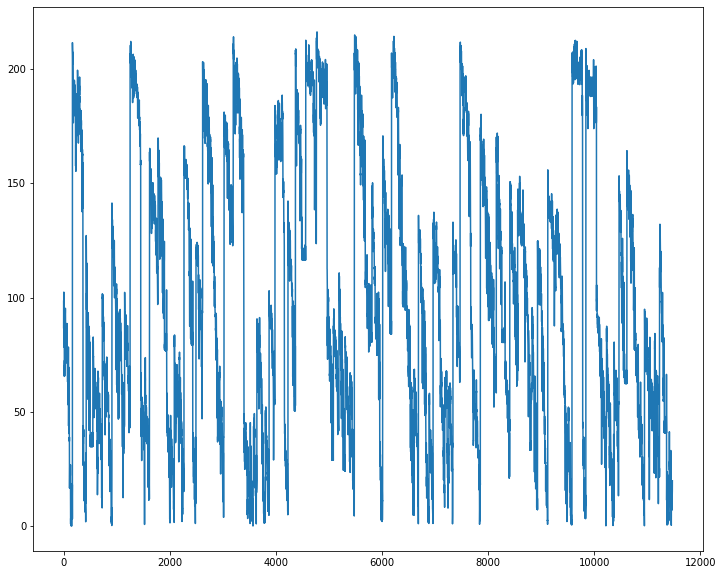

In [11]:
import matplotlib.pyplot as plt

fig_y = []
for i in range(len(pred)):
    error = np.sqrt(np.power((r_memory_df.comb_reward[i] - pred[i]), 2))
    fig_y.append(error)

fig = plt.figure(figsize=(12,10))
plt.plot([i for i in range(len(pred))], fig_y)
plt.show()
    

In [12]:
np.array(fig_y).mean()

98.86905516339868

In [ ]:
t = n()
num_episodes = 100
r_life_memory2 = []
r_env = gym.make('CartPole-v0')
pred2 = []
for i in range(num_episodes):
    r_old_observation = r_env.reset()
    r_done = False
    r_tot_reward = 0
    r_em_memory2 = []
    while not r_done:
        pred_in = [list(r_old_observation) + [i] for i in range(2)]
        r_new_action = np.argmax(RandomForest2.predict(pred_in))
        r_observation, r_reward, r_done, r_info = r_env.step(r_new_action)
        r_tot_reward += r_reward
        
        r_em_memory2.append({
            "obs0": r_old_observation[0],
            "obs1": r_old_observation[1],
            "obs2": r_old_observation[2],
            "obs3": r_old_observation[3],
            "action": r_new_action,
            "reward": r_reward,
            "episode": i,
        })
        
        pred2.append(RandomForest2.predict([list(r_old_observation) + [r_new_action]]))

        r_old_observation = r_observation
        
    for r_em in r_em_memory2:
        r_em["tot_reward"] = r_tot_reward
        
    r_life_memory2.extend(r_em_memory2)
r_memory_df2 = pandas.DataFrame(r_life_memory2)
print(f"Training time: {n() - t}s")

In [ ]:
r_memory_df2.groupby('episode').reward.sum().mean()

In [ ]:
(r_memory_df2.groupby('episode').reward.sum() >= 200).value_counts()

In [ ]:
r_memory_df2["comb_reward"] = .5*r_memory_df2.reward + 1.2 * r_memory_df2.tot_reward

In [ ]:
len(r_memory_df2)

In [ ]:
len(pred2)

In [ ]:
fig_y2 = []
for i in range(len(pred2)):
    error = np.sqrt(np.power((r_memory_df2.comb_reward[i] - pred2[i]), 2))
    fig_y2.append(error)

fig = plt.figure(figsize=(12,10))
plt.plot([i for i in range(len(pred2))], fig_y2)
plt.show()   

In [ ]:
np.array(fig_y2).mean()

In [ ]:
import datetime 

n = datetime.datetime.now
t = n()

In [ ]:
t = n()
num_episodes = 100
e_life_memory = []
e_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    e_old_observation = e_env.reset()
    e_done = False
    e_tot_reward = 0
    e_em_memory = []
    while not e_done:
        pred_in = [list(e_old_observation) + [i] for i in range(2)]
        e_new_action = np.argmax(ExtraTrees.predict(pred_in))
        e_observation, e_reward, e_done, e_info = e_env.step(e_new_action)
        e_tot_reward += e_reward
        e_em_memory.append({
            "obs0": e_old_observation[0],
            "obs1": e_old_observation[1],
            "obs2": e_old_observation[2],
            "obs3": e_old_observation[3],
            "action": e_new_action,
            "reward": e_reward,
            "episode": i,
        })
        
        e_old_observation = e_observation

    for e_em in e_em_memory:
        e_em["tot_reward"] = e_tot_reward
    e_life_memory.extend(e_em_memory)
e_memory_df = pandas.DataFrame(e_life_memory)
print(f"Training time: {n() - t}s")

In [ ]:
e_env.reset()
e_env.step(1)

In [ ]:
np.argmax(ExtraTrees.predict([[ 0.03719052,  0.20216305,  0.01937592, -0.24454289, 1], [ 0.03719052,  0.20216305,  0.01937592, -0.24454289, 0]]))

In [ ]:
r_memory_df.groupby("episode").reward.sum().mean()

In [ ]:
(r_memory_df.groupby("episode").reward.sum() >= 200).value_counts()

In [ ]:
a_memory_df.groupby("episode").reward.sum().mean()

In [ ]:
(a_memory_df.groupby("episode").reward.sum() >= 200).value_counts()

In [ ]:
e_memory_df.groupby("episode").reward.sum().mean()

In [ ]:
(e_memory_df.groupby("episode").reward.sum() >= 200).value_counts()

In [ ]:
[i for i in range(50, 40)]

In [ ]:
memory_df.shape

In [ ]:
x = memory_df[["obs0", "obs1", "obs2", "obs3", "action"]]
y = memory_df.comb_reward

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [ ]:
ENCODING_DIM = 64
HIDDEN_DIM = 256
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(5,)) 
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(inputs)
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(1, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [ ]:
# full_model = Model(inputs=inputs, 
#                    outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [ ]:
full_model.summary()

In [ ]:
history = full_model.fit(x, y, shuffle=True, epochs=5)

In [ ]:
memory_df

In [13]:
x_mat = memory_df[["obs0", "obs1", "obs2", "obs3", "action"]].to_numpy()
y = memory_df['comb_reward'].to_numpy()
# num_ = memory_df.shape[0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
s = MinMaxScaler()
y = s.fit_transform(y.reshape(-1,1))
y = y.reshape(-1,)

In [14]:
W_1 = np.random.uniform(-1,1,size=(5,8))
W_2 = np.random.uniform(-1,1,size=(8))

In [ ]:
x_mat

In [15]:
# Practice
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# def loss_fn(y_true, y_pred, eps=1e-16):
#     """
#     Loss function we would like to optimize (minimize)
#     We are using Logarithmic Loss
#     http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
#     """
#     y_pred = np.maximum(y_pred,eps)
#     y_pred = np.minimum(y_pred,(1-eps))
#     return -(np.sum(y_true * np.log(y_pred)) + np.sum((1-y_true)*np.log(1-y_pred)))/len(y_true)

def relu(x):
    return np.maximum(0, x)

def forward_pass(W_1, W_2):
    global x_mat
    global y
    global num_

    z_2 = np.dot(x_mat, W_1)    # (221191 , 5) x (5, 64) = (221191 , 64)
    a_2 = sigmoid(z_2)          # (221191 , 64)
    z_3 = np.dot(a_2, W_2)      # (221191 , 64) x (64, ) = (221191 , )
    y_pred = sigmoid(z_3).reshape((len(x_mat),))      # (221191 , )
    J_z_3_grad = -y + y_pred      # (221191 , )
    J_W_2_grad = np.dot(J_z_3_grad, a_2)      # (221191 , ) x (221191 , 64) = (64, )
    a_2_z_2_grad = sigmoid(z_2)*(1 - sigmoid(z_2))  # (221191 , 64) * (221191 , 64) = (221191 , 64)
                                                    #     J_W_1_grad = a_1 * a_2_z_2_grad * W_2 * J_z_3_grad
                                                    #     J_W_1_grad = np.dot(x_mat, a_2_z_2_grad).dot(W_2).dot(J_z_3_grad)
    J_W_1_grad = (np.dot((J_z_3_grad).reshape(-1,1), W_2.reshape(-1,1).T)*a_2_z_2_grad).T.dot(x_mat).T
# (221191 , )->(221191 , 1) x (64 x 1).T = (221191 , 64) * (221191 , 64) = (221191 , 64).T = (64, 221191 ) x (221191 , 5)
# = (64, 5).T = (5, 64)
    gradient = (J_W_1_grad, J_W_2_grad)
    
    return y_pred, gradient

# def plot_loss_accuracy(loss_vals, accuracies):
#     fig = plt.figure(figsize=(16, 8))
#     fig.suptitle('Log Loss and Accuracy over iterations')
    
#     ax = fig.add_subplot(1, 2, 1)
#     ax.plot(loss_vals)
#     ax.grid(True)
#     ax.set(xlabel='iterations', title='Log Loss')
    
#     ax = fig.add_subplot(1, 2, 2)
#     ax.plot(accuracies)
#     ax.grid(True)
#     ax.set(xlabel='iterations', title='Accuracy');

In [16]:
# Practice
import datetime
n = datetime.datetime.now
t = n()

np.random.seed(1241)

num_iter = 50
learning_rate = .001
# x_mat = x_mat_full

total_pred = []
for i in range(num_iter):
    y_pred, (J_W_1_grad, J_W_2_grad) = forward_pass(W_1, W_2)
    
    W_1 = W_1 - learning_rate * J_W_1_grad
    W_2 = W_2 - learning_rate * J_W_2_grad
    
    total_pred.append(y_pred)
print(f"Training time: {n() - t}s")

C:\Users\moon\AppData\Local\Temp/ipykernel_29512/2272599921.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Training time: 0:00:01.157572s


In [ ]:
# total_pred[0]

In [ ]:
# y

In [ ]:
errorfi = np.sqrt(np.power((y - total_pred[0]), 2))
errorff = np.sqrt(np.power((y - total_pred[-1]), 2))

In [ ]:
# W_2

In [ ]:
# errorfi

In [ ]:
# errorff

In [ ]:
errorfi.sum()/len(errorfi)

In [ ]:
errorff.sum()/len(errorff)

In [ ]:
# a = np.array([1,2,3])
# b = np.array([2,4,9])
# np.power((b - a), 2).mean()

In [ ]:
fig_y3 = []
for i in range(len(total_pred)):
    errorfi = np.sqrt(np.power((y - total_pred[i]), 2).mean())
    fig_y3.append(errorfi)

In [ ]:
len(fig_y3)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot([i for i in range(len(fig_y3))], fig_y3, marker='o')
# plt.xlim(900, 1000)
plt.show()

In [ ]:
def nn_predict(pred_in):
    z_2 = np.dot(pred_in[0], W_1)
    a_2 = sigmoid(z_2)
    z_3 = np.dot(a_2, W_2)
    y_pred1 = sigmoid(z_3)
    
    z2_2 = np.dot(pred_in[1], W_1)
    a2_2 = sigmoid(z2_2)
    z2_3 = np.dot(a2_2, W_2)
    y_pred2 = sigmoid(z2_3)
    
    return y_pred1, y_pred2

In [ ]:
t = n()
num_episodes = 100
n_life_memory = []
n_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    n_old_observation = n_env.reset()
    n_done = False
    n_tot_reward = 0
    n_em_memory = []
    while not n_done:
        pred_in = [list(n_old_observation) + [i] for i in range(2)]
        n_new_action = np.argmax([nn_predict(pred_in)])
        n_observation, n_reward, n_done, n_info = n_env.step(n_new_action)
        n_tot_reward += n_reward
        n_em_memory.append({
            "obs0": n_old_observation[0],
            "obs1": n_old_observation[1],
            "obs2": n_old_observation[2],
            "obs3": n_old_observation[3],
            "action": n_new_action,
            "reward": n_reward,
            "episode": i,
        })
        
        n_old_observation = n_observation

    for n_em in n_em_memory:
        n_em["tot_reward"] = n_tot_reward
    n_life_memory.extend(n_em_memory)
n_memory_df = pandas.DataFrame(n_life_memory)
print(f"Training time: {n() - t}s")

In [ ]:
n_memory_df

In [ ]:
n_memory_df.groupby("episode").reward.sum().mean()

In [ ]:
(n_memory_df.groupby("episode").reward.sum() >= 200).value_counts()

In [ ]:
x_mat.shape

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers

# optimizer = tf.keras.optimizers.RMSprop(0.001)

def build_model1():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(x_mat.shape[1], )))
#     model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [28]:
model1 = build_model1()
model1.fit(x_mat, y, epochs = 100)

Epoch 1/100
695/695 [==============================] - 1s 750us/step - loss: 935.9998 - mae: 23.7269
Epoch 2/100
695/695 [==============================] - 1s 816us/step - loss: 403.0857 - mae: 15.0692
Epoch 3/100
695/695 [==============================] - 1s 774us/step - loss: 364.2706 - mae: 14.4562
Epoch 4/100
695/695 [==============================] - 1s 831us/step - loss: 358.5028 - mae: 14.3767
Epoch 5/100
695/695 [==============================] - 1s 808us/step - loss: 352.7475 - mae: 14.2667
Epoch 6/100
695/695 [==============================] - 1s 839us/step - loss: 345.0305 - mae: 14.1078
Epoch 7/100
695/695 [==============================] - 1s 764us/step - loss: 335.3260 - mae: 13.8968
Epoch 8/100
695/695 [==============================] - 1s 762us/step - loss: 323.7812 - mae: 13.6531
Epoch 9/100
695/695 [==============================] - 1s 763us/step - loss: 310.2866 - mae: 13.3776
Epoch 10/100
695/695 [==============================] - 1s 783us/step - loss: 295.9395 - ma

695/695 [==============================] - 1s 878us/step - loss: 222.5219 - mae: 10.9315
Epoch 81/100
695/695 [==============================] - 1s 828us/step - loss: 222.3673 - mae: 10.9378
Epoch 82/100
695/695 [==============================] - 1s 848us/step - loss: 222.3162 - mae: 10.9240
Epoch 83/100
695/695 [==============================] - 1s 866us/step - loss: 222.1980 - mae: 10.9070
Epoch 84/100
695/695 [==============================] - 1s 871us/step - loss: 222.2139 - mae: 10.9308
Epoch 85/100
695/695 [==============================] - 1s 840us/step - loss: 222.0371 - mae: 10.9105
Epoch 86/100
695/695 [==============================] - 1s 756us/step - loss: 222.0097 - mae: 10.9206
Epoch 87/100
695/695 [==============================] - 1s 774us/step - loss: 222.0032 - mae: 10.9204
Epoch 88/100
695/695 [==============================] - 1s 749us/step - loss: 221.8045 - mae: 10.9103
Epoch 89/100
695/695 [==============================] - 1s 761us/step - loss: 221.8311 - mae: 1

In [29]:
t = n()
num_episodes = 10
n_life_memory1 = []
n_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    n_old_observation = n_env.reset()
    n_done = False
    n_tot_reward = 0
    n_em_memory1 = []
    while not n_done:
        pred_in = [list(n_old_observation) + [i] for i in range(2)]
        n_new_action = np.argmax([model1.predict(pred_in)])
        n_observation, n_reward, n_done, n_info = n_env.step(n_new_action)
        n_tot_reward += n_reward
        n_em_memory1.append({
            "obs0": n_old_observation[0],
            "obs1": n_old_observation[1],
            "obs2": n_old_observation[2],
            "obs3": n_old_observation[3],
            "action": n_new_action,
            "reward": n_reward,
            "episode": i,
        })
        
        n_old_observation = n_observation

    for n_em in n_em_memory1:
        n_em["tot_reward"] = n_tot_reward
    n_life_memory1.extend(n_em_memory1)
n_memory_df1 = pandas.DataFrame(n_life_memory1)
print(f"Training time: {n() - t}s")

Training time: 0:01:10.516190s


In [30]:
n_memory_df1.groupby('episode').reward.sum().mean()

172.8

In [31]:
(n_memory_df1.groupby('episode').reward.sum() >= 200).value_counts()

True     5
False    5
Name: reward, dtype: int64

In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers

# optimizer = tf.keras.optimizers.RMSprop(0.001)

def build_model2():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(x_mat.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [36]:
model2 = build_model2()
model2.fit(x_mat, y, epochs = 100)

Epoch 1/100
695/695 [==============================] - 1s 866us/step - loss: 538.6140 - mae: 17.3431
Epoch 2/100
695/695 [==============================] - 1s 880us/step - loss: 339.2955 - mae: 14.0555
Epoch 3/100
695/695 [==============================] - 1s 1ms/step - loss: 285.3219 - mae: 12.8211
Epoch 4/100
695/695 [==============================] - 1s 956us/step - loss: 245.3028 - mae: 11.6896
Epoch 5/100
695/695 [==============================] - 1s 1ms/step - loss: 235.2709 - mae: 11.3326
Epoch 6/100
695/695 [==============================] - 1s 944us/step - loss: 232.1004 - mae: 11.2158
Epoch 7/100
695/695 [==============================] - 1s 1ms/step - loss: 229.9737 - mae: 11.1543
Epoch 8/100
695/695 [==============================] - 1s 1ms/step - loss: 227.5175 - mae: 11.0755
Epoch 9/100
695/695 [==============================] - 1s 1ms/step - loss: 225.3427 - mae: 11.0221
Epoch 10/100
695/695 [==============================] - 1s 1ms/step - loss: 223.7870 - mae: 10.9743
E

695/695 [==============================] - 1s 950us/step - loss: 200.4897 - mae: 10.2094
Epoch 82/100
695/695 [==============================] - 1s 935us/step - loss: 200.0910 - mae: 10.2111
Epoch 83/100
695/695 [==============================] - 1s 914us/step - loss: 200.0364 - mae: 10.1815
Epoch 84/100
695/695 [==============================] - 1s 926us/step - loss: 199.8094 - mae: 10.1817
Epoch 85/100
695/695 [==============================] - 1s 906us/step - loss: 199.7741 - mae: 10.1866
Epoch 86/100
695/695 [==============================] - 1s 928us/step - loss: 199.4401 - mae: 10.1737
Epoch 87/100
695/695 [==============================] - 1s 926us/step - loss: 199.7622 - mae: 10.1865
Epoch 88/100
695/695 [==============================] - 1s 919us/step - loss: 199.5882 - mae: 10.1784
Epoch 89/100
695/695 [==============================] - 1s 936us/step - loss: 199.4207 - mae: 10.1846
Epoch 90/100
695/695 [==============================] - 1s 1ms/step - loss: 199.6069 - mae: 10.

In [50]:
t = n()
num_episodes = 10
n_life_memory2 = []
n_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    n_old_observation = n_env.reset()
    n_done = False
    n_tot_reward = 0
    n_em_memory2 = []
    while not n_done:
        pred_in = [list(n_old_observation) + [i] for i in range(2)]
        n_new_action = np.argmax([model2.predict(pred_in)])
        n_observation, n_reward, n_done, n_info = n_env.step(n_new_action)
        n_tot_reward += n_reward
        n_em_memory2.append({
            "obs0": n_old_observation[0],
            "obs1": n_old_observation[1],
            "obs2": n_old_observation[2],
            "obs3": n_old_observation[3],
            "action": n_new_action,
            "reward": n_reward,
            "episode": i,
        })
        
        n_old_observation = n_observation

    for n_em in n_em_memory2:
        n_em["tot_reward"] = n_tot_reward
    n_life_memory2.extend(n_em_memory2)
n_memory_df2 = pandas.DataFrame(n_life_memory2)
print(f"Training time: {n() - t}s")

KeyboardInterrupt: 

In [38]:
n_memory_df2.groupby('episode').reward.sum().mean()

173.5

In [39]:
(n_memory_df2.groupby('episode').reward.sum() >= 200).value_counts()

True     6
False    4
Name: reward, dtype: int64

In [40]:
def build_model3():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(x_mat.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [41]:
model3 = build_model3()
model3.fit(x_mat, y, epochs = 100)

Epoch 1/100
695/695 [==============================] - 1s 919us/step - loss: 424.0009 - mae: 15.3641
Epoch 2/100
695/695 [==============================] - 1s 918us/step - loss: 246.4792 - mae: 11.6811
Epoch 3/100
695/695 [==============================] - 1s 920us/step - loss: 236.4876 - mae: 11.3444
Epoch 4/100
695/695 [==============================] - 1s 935us/step - loss: 230.5623 - mae: 11.1819
Epoch 5/100
695/695 [==============================] - 1s 1ms/step - loss: 226.0118 - mae: 11.0319
Epoch 6/100
695/695 [==============================] - 1s 1ms/step - loss: 222.2379 - mae: 10.9278
Epoch 7/100
695/695 [==============================] - 1s 886us/step - loss: 218.8046 - mae: 10.7995
Epoch 8/100
695/695 [==============================] - 1s 877us/step - loss: 216.0057 - mae: 10.7072
Epoch 9/100
695/695 [==============================] - 1s 960us/step - loss: 214.4664 - mae: 10.6589
Epoch 10/100
695/695 [==============================] - 1s 1ms/step - loss: 213.2166 - mae: 10.

695/695 [==============================] - 1s 894us/step - loss: 197.2143 - mae: 10.1111
Epoch 82/100
695/695 [==============================] - 1s 872us/step - loss: 197.3018 - mae: 10.1065
Epoch 83/100
695/695 [==============================] - 1s 868us/step - loss: 197.5018 - mae: 10.1260
Epoch 84/100
695/695 [==============================] - 1s 873us/step - loss: 197.3461 - mae: 10.1058
Epoch 85/100
695/695 [==============================] - 1s 882us/step - loss: 197.4301 - mae: 10.1084
Epoch 86/100
695/695 [==============================] - 1s 865us/step - loss: 197.1735 - mae: 10.1049
Epoch 87/100
695/695 [==============================] - 1s 862us/step - loss: 196.5491 - mae: 10.0860
Epoch 88/100
695/695 [==============================] - 1s 885us/step - loss: 196.6101 - mae: 10.0806
Epoch 89/100
695/695 [==============================] - 1s 928us/step - loss: 196.5123 - mae: 10.0900
Epoch 90/100
695/695 [==============================] - 1s 913us/step - loss: 196.2787 - mae: 1

In [42]:
t = n()
num_episodes = 10
n_life_memory3 = []
n_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    n_old_observation = n_env.reset()
    n_done = False
    n_tot_reward = 0
    n_em_memory3 = []
    while not n_done:
        pred_in = [list(n_old_observation) + [i] for i in range(2)]
        n_new_action = np.argmax([model3.predict(pred_in)])
        n_observation, n_reward, n_done, n_info = n_env.step(n_new_action)
        n_tot_reward += n_reward
        n_em_memory3.append({
            "obs0": n_old_observation[0],
            "obs1": n_old_observation[1],
            "obs2": n_old_observation[2],
            "obs3": n_old_observation[3],
            "action": n_new_action,
            "reward": n_reward,
            "episode": i,
        })
        
        n_old_observation = n_observation

    for n_em in n_em_memory3:
        n_em["tot_reward"] = n_tot_reward
    n_life_memory3.extend(n_em_memory3)
n_memory_df3 = pandas.DataFrame(n_life_memory3)
print(f"Training time: {n() - t}s")

Training time: 0:01:19.295648s


In [43]:
n_memory_df3.groupby('episode').reward.sum().mean()

195.6

In [44]:
(n_memory_df3.groupby('episode').reward.sum() >= 200).value_counts()

True     8
False    2
Name: reward, dtype: int64

In [45]:
def build_model4():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape=(x_mat.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [46]:
model4 = build_model4()
model4.fit(x_mat, y, epochs = 100)

Epoch 1/100
695/695 [==============================] - 1s 1ms/step - loss: 352.2249 - mae: 13.8791
Epoch 2/100
695/695 [==============================] - 1s 969us/step - loss: 235.4891 - mae: 11.3316
Epoch 3/100
695/695 [==============================] - 1s 942us/step - loss: 230.4027 - mae: 11.1668
Epoch 4/100
695/695 [==============================] - 1s 1ms/step - loss: 226.5423 - mae: 11.0315
Epoch 5/100
695/695 [==============================] - 1s 953us/step - loss: 222.4747 - mae: 10.9139
Epoch 6/100
695/695 [==============================] - 1s 948us/step - loss: 220.0939 - mae: 10.8440
Epoch 7/100
695/695 [==============================] - 1s 978us/step - loss: 217.2787 - mae: 10.7497
Epoch 8/100
695/695 [==============================] - 1s 981us/step - loss: 215.5845 - mae: 10.6851
Epoch 9/100
695/695 [==============================] - 1s 974us/step - loss: 213.1143 - mae: 10.6145
Epoch 10/100
695/695 [==============================] - 1s 1ms/step - loss: 211.6570 - mae: 10.

695/695 [==============================] - 1s 1ms/step - loss: 192.9182 - mae: 9.9993
Epoch 83/100
695/695 [==============================] - 1s 1ms/step - loss: 193.3634 - mae: 9.9876
Epoch 84/100
695/695 [==============================] - 1s 969us/step - loss: 193.3673 - mae: 9.9969
Epoch 85/100
695/695 [==============================] - 1s 1ms/step - loss: 192.6211 - mae: 9.9828
Epoch 86/100
695/695 [==============================] - 1s 993us/step - loss: 192.3822 - mae: 9.9702
Epoch 87/100
695/695 [==============================] - 1s 1ms/step - loss: 192.4038 - mae: 9.9623
Epoch 88/100
695/695 [==============================] - 1s 1ms/step - loss: 192.3893 - mae: 9.9573
Epoch 89/100
695/695 [==============================] - 1s 1ms/step - loss: 192.8146 - mae: 9.9777
Epoch 90/100
695/695 [==============================] - 1s 1ms/step - loss: 191.8726 - mae: 9.9544
Epoch 91/100
695/695 [==============================] - 1s 1ms/step - loss: 191.8332 - mae: 9.9583
Epoch 92/100
695/69

In [47]:
t = n()
num_episodes = 10
n_life_memory4 = []
n_env = gym.make('CartPole-v0')
for i in range(num_episodes):
    n_old_observation = n_env.reset()
    n_done = False
    n_tot_reward = 0
    n_em_memory4 = []
    while not n_done:
        pred_in = [list(n_old_observation) + [i] for i in range(2)]
        n_new_action = np.argmax([model4.predict(pred_in)])
        n_observation, n_reward, n_done, n_info = n_env.step(n_new_action)
        n_tot_reward += n_reward
        n_em_memory4.append({
            "obs0": n_old_observation[0],
            "obs1": n_old_observation[1],
            "obs2": n_old_observation[2],
            "obs3": n_old_observation[3],
            "action": n_new_action,
            "reward": n_reward,
            "episode": i,
        })
        
        n_old_observation = n_observation

    for n_em in n_em_memory4:
        n_em["tot_reward"] = n_tot_reward
    n_life_memory4.extend(n_em_memory4)
n_memory_df4 = pandas.DataFrame(n_life_memory4)
print(f"Training time: {n() - t}s")

Training time: 0:01:01.719923s


In [48]:
n_memory_df4.groupby('episode').reward.sum().mean()

133.7

In [49]:
(n_memory_df4.groupby('episode').reward.sum() >= 200).value_counts()

False    9
True     1
Name: reward, dtype: int64